In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
#from imblearn.combine import SMOTEENN, SMOTETomek 
from sklearn import metrics, tree, preprocessing, model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from collections import Counter
from scipy.stats import boxcox
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree

In [2]:
#Import data
data = pd.read_csv('heart_2020_cleaned.csv')
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [3]:
#Initial data and attributes review
data.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
features = data.columns.tolist()
Num_features = [feature for feature in features if data[feature].dtype != object]
Cat_features = [feature for feature in features if data[feature].dtype == object]

In [6]:
Num_features

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

In [7]:
Cat_features

['HeartDisease',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [8]:
for i in range(0,len(Cat_features)):
    print(Cat_features[i],': ',set(data[Cat_features[i]].values.tolist()))

HeartDisease :  {'Yes', 'No'}
Smoking :  {'Yes', 'No'}
AlcoholDrinking :  {'Yes', 'No'}
Stroke :  {'Yes', 'No'}
DiffWalking :  {'Yes', 'No'}
Sex :  {'Male', 'Female'}
AgeCategory :  {'50-54', '45-49', '30-34', '18-24', '65-69', '70-74', '60-64', '75-79', '25-29', '55-59', '80 or older', '35-39', '40-44'}
Race :  {'American Indian/Alaskan Native', 'White', 'Other', 'Black', 'Hispanic', 'Asian'}
Diabetic :  {'Yes (during pregnancy)', 'Yes', 'No, borderline diabetes', 'No'}
PhysicalActivity :  {'Yes', 'No'}
GenHealth :  {'Very good', 'Good', 'Fair', 'Poor', 'Excellent'}
Asthma :  {'Yes', 'No'}
KidneyDisease :  {'Yes', 'No'}
SkinCancer :  {'Yes', 'No'}


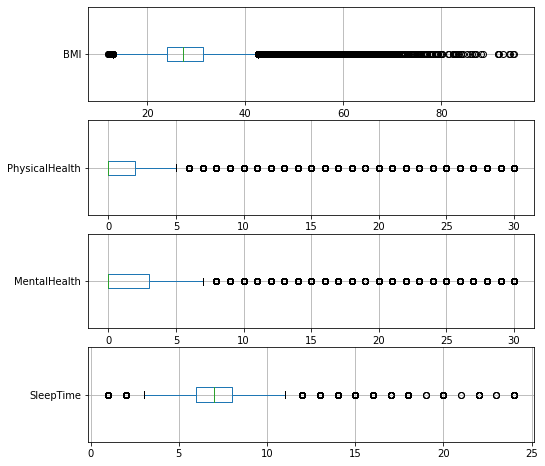

In [9]:
#Data exploration - Numerical Features
#Box plots
fig, axes = plt.subplots(4,1 ,figsize=(8,8))
for i,c in enumerate(Num_features):
    f = data[[c]].boxplot(ax=axes[i], vert=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe42abbccd0>,
      dtype=object)

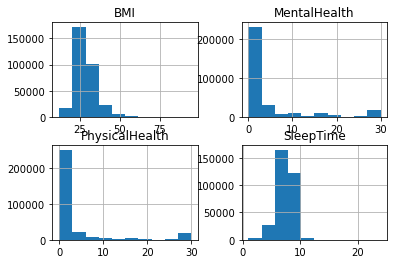

In [10]:
#histograms
data.hist()

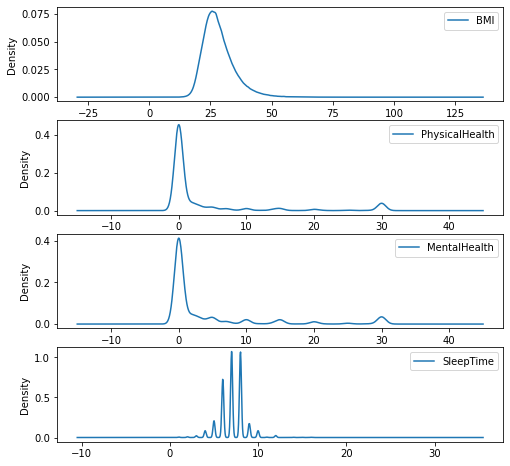

In [11]:
#kernel density estimation plot
fig, axes = plt.subplots(4,1 ,figsize=(8,8))
for i,c in enumerate(Num_features):
    f = data[[c]].plot(kind = 'kde', ax=axes[i])

In [12]:
#Calculate Skewness scores:
for c in Num_features:
    print('Skewness of',c,':',data[c].skew())

Skewness of BMI : 1.3324306428979513
Skewness of PhysicalHealth : 2.6039732622480822
Skewness of MentalHealth : 2.331111549136165
Skewness of SleepTime : 0.6790346208011537


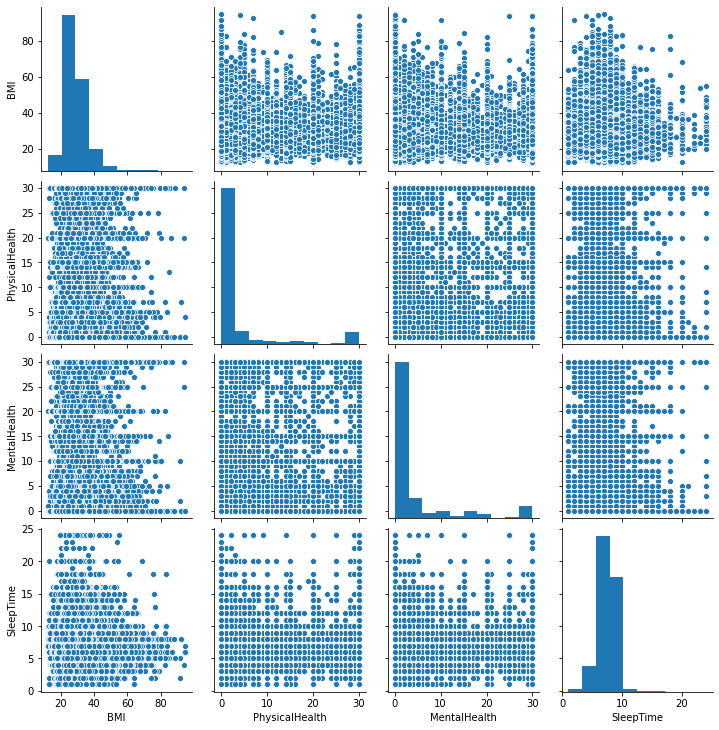

In [13]:
#PairPlot
sns.pairplot(data[Num_features])

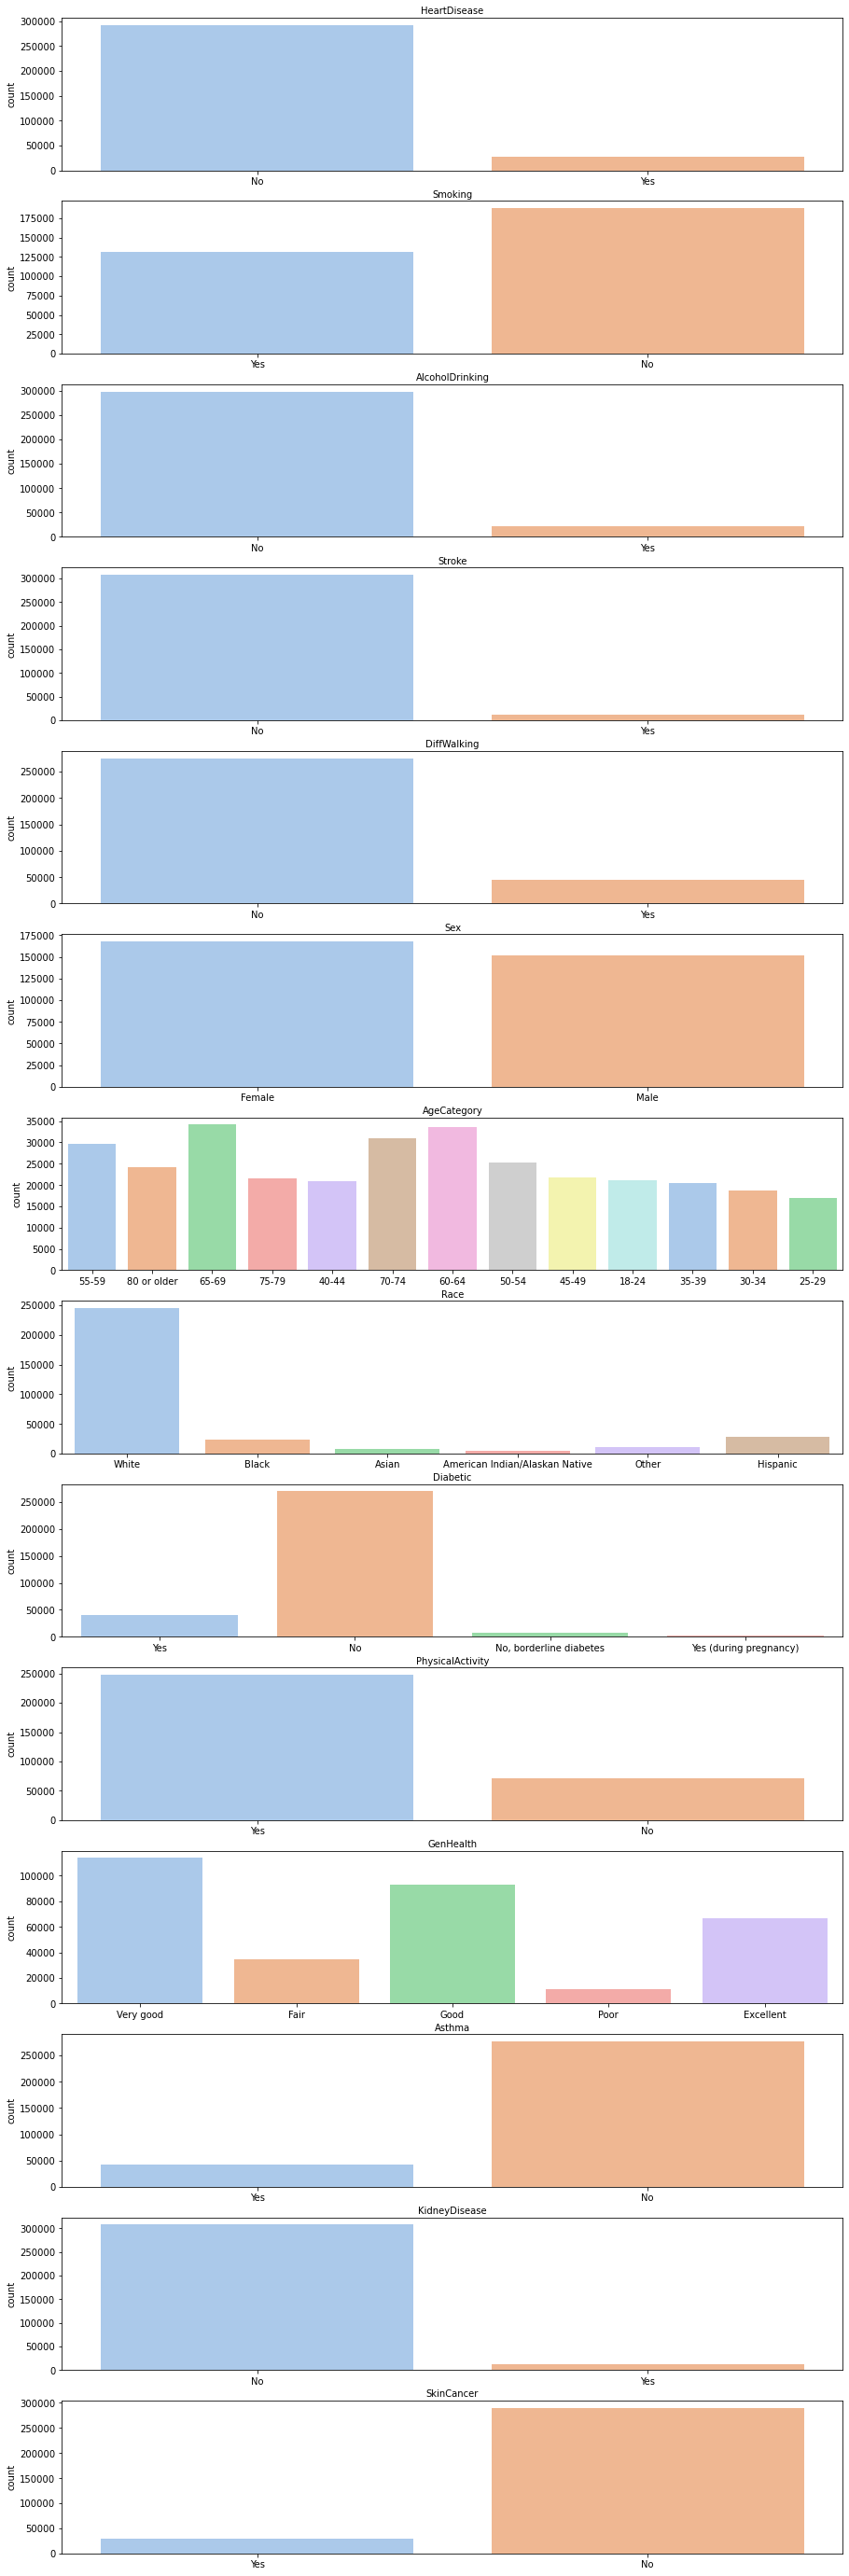

In [14]:
#Data exploration - Categorical features
fig, axes = plt.subplots(14,1 ,figsize=(15,50))
for i,c in enumerate(Cat_features):
    countplot = sns.countplot(x=c,data=data, ax=axes[i],palette=sns.color_palette("pastel"))
    countplot.xaxis.set_label_position('top')

In [15]:
#LabelEncoding for categorical features
le = preprocessing.LabelEncoder()
for c in Cat_features:
    data[c]=le.fit_transform(data[c])
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,5,2,1,4,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,4,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,5,2,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,11,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4,5,0,1,4,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,8,3,2,0,1,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,3,3,0,1,4,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,0,5,3,0,1,2,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,0,1,3,0,0,2,12.0,0,0,0


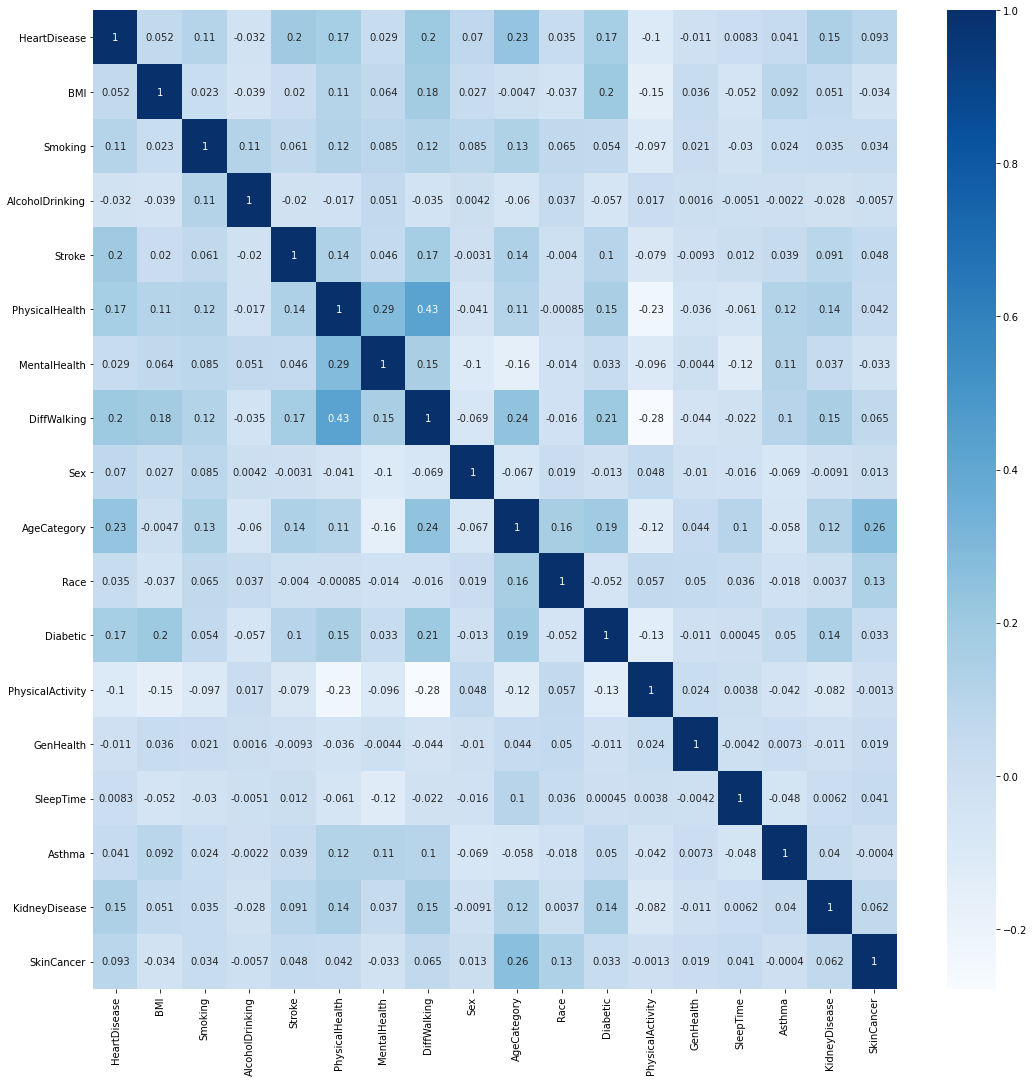

In [16]:
#Pearson Correlation matrix for all features
corr_matrix = data[features].corr(method='pearson')
plt.figure(figsize=(18,18))
correc = sns.heatmap(corr_matrix, annot=True, cmap = 'Blues')

In [17]:
#Data cleaning
#Since there are no null values, we don't need imputation, data is complete
#data = data.dropna(subset=data.columns.tolist())

In [18]:
#Handle skewed data and new plots
data['BMI'] = boxcox(data.iloc[:, 1])[0]
data['PhysicalHealth'] = data['PhysicalHealth'].map(lambda x: np.log(x) if x !=0 else 0)
data['MentalHealth'] = data['MentalHealth'].map(lambda x: np.log(x) if x !=0 else 0)
data['SleepTime'] = boxcox(data.iloc[:, 14])[0]
data

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,1.338416,1,0,0,1.098612,3.401197,0,0,7,5,2,1,4,3.410537,1,0,1
1,0,1.372448,0,0,1,0.000000,0.000000,0,0,12,5,0,1,4,4.913324,0,0,0
2,0,1.411251,1,0,0,2.995732,3.401197,0,1,9,5,2,1,1,5.637834,1,0,0
3,0,1.398425,0,0,0,0.000000,0.000000,0,0,11,5,0,0,2,4.172000,0,0,1
4,0,1.395457,0,0,0,3.332205,0.000000,1,0,4,5,0,1,4,5.637834,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,1.415315,1,0,0,1.945910,0.000000,1,1,8,3,2,0,1,4.172000,1,0,0
319791,0,1.426152,1,0,0,0.000000,0.000000,0,1,3,3,0,1,4,3.410537,1,0,0
319792,0,1.398600,0,0,0,0.000000,0.000000,0,0,5,3,0,1,2,4.172000,0,0,0
319793,0,1.437608,0,0,0,0.000000,0.000000,0,0,1,3,0,0,2,8.408589,0,0,0


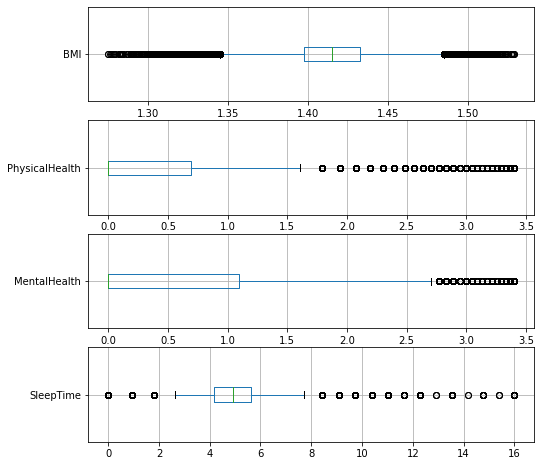

In [19]:
#New plots after transformations
fig, axes = plt.subplots(4,1 ,figsize=(8,8))
for i,c in enumerate(Num_features):
    f = data[[c]].boxplot(ax=axes[i], vert=False)

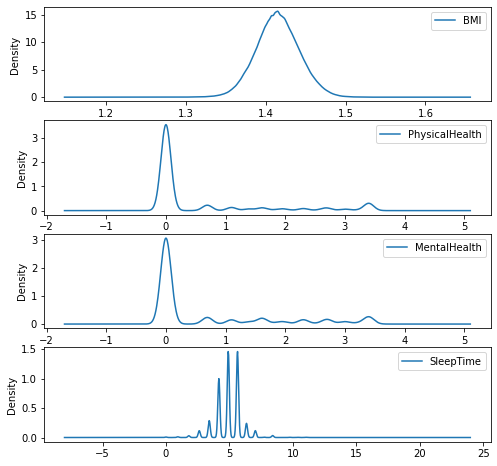

In [20]:
fig, axes = plt.subplots(4,1 ,figsize=(8,8))
for i,c in enumerate(Num_features):
    f2 = data[[c]].plot(kind = 'kde', ax=axes[i])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe416f2ef70>,
      dtype=object)

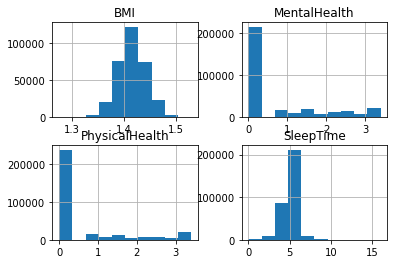

In [21]:
data[Num_features].hist()

In [22]:
#Calculate Skewness scores:
for c in Num_features:
    print('Skewness of',c,':',data[c].skew())

Skewness of BMI : -0.010319261170548688
Skewness of PhysicalHealth : 1.7839610973953444
Skewness of MentalHealth : 1.377076131860236
Skewness of SleepTime : 0.2994669103417153


In [23]:
#Split data into features (X) and labels (y)
X = data.drop(['HeartDisease'], axis=1)
y = data['HeartDisease']
features.remove('HeartDisease') #Remove HeartDisease from the list of features, it's the label

In [24]:
X

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,1.338416,1,0,0,1.098612,3.401197,0,0,7,5,2,1,4,3.410537,1,0,1
1,1.372448,0,0,1,0.000000,0.000000,0,0,12,5,0,1,4,4.913324,0,0,0
2,1.411251,1,0,0,2.995732,3.401197,0,1,9,5,2,1,1,5.637834,1,0,0
3,1.398425,0,0,0,0.000000,0.000000,0,0,11,5,0,0,2,4.172000,0,0,1
4,1.395457,0,0,0,3.332205,0.000000,1,0,4,5,0,1,4,5.637834,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1.415315,1,0,0,1.945910,0.000000,1,1,8,3,2,0,1,4.172000,1,0,0
319791,1.426152,1,0,0,0.000000,0.000000,0,1,3,3,0,1,4,3.410537,1,0,0
319792,1.398600,0,0,0,0.000000,0.000000,0,0,5,3,0,1,2,4.172000,0,0,0
319793,1.437608,0,0,0,0.000000,0.000000,0,0,1,3,0,0,2,8.408589,0,0,0


In [25]:
#Check if labels are balanced
Counter(y)

Counter({0: 292422, 1: 27373})

In [26]:
#Handle imbalanced data
sm = SMOTE(random_state=2)
#sm = SMOTEENN(random_state=42)
#sm = SMOTETomek(random_state=42)
X, y = sm.fit_resample(X, y)

In [27]:
#Check if labels are balanced
Counter(y)

Counter({0: 292422, 1: 292422})

In [28]:
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32,stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(467875, 17) (116969, 17) (467875,) (116969,)


In [29]:
Counter(y_train)

Counter({1: 233937, 0: 233938})

In [30]:
Counter(y_test)

Counter({0: 58484, 1: 58485})

In [31]:
#Normalize and scale data, reduces impact of outliers
transformation = RobustScaler()
d = transformation.fit(X_train)
X_train = d.transform(X_train)
X_test = d.transform(X_test)

In [32]:
#Define function for metrics
def metrics_plot(y_test,y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #Plot of confusion matrix
    class_names=['No','Yes'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    #Create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap=sns.color_palette("Blues") ,fmt='g')
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    #Print additional metrics
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("F1 Score:",metrics.f1_score(y_test, y_pred))
    print("Classification Report:\n",classification_report(y_test,y_pred))

Accuracy: 0.7436243791089947
Precision: 0.727528224454274
Recall: 0.7790031632042405
F1 Score: 0.7523862998315554
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73     58484
           1       0.73      0.78      0.75     58485

    accuracy                           0.74    116969
   macro avg       0.74      0.74      0.74    116969
weighted avg       0.74      0.74      0.74    116969



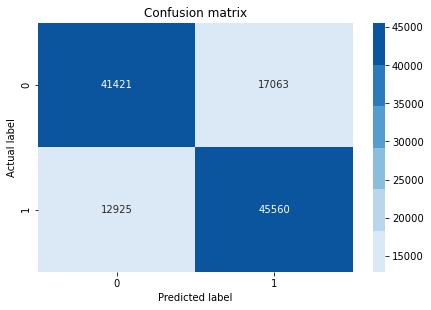

In [33]:
#Classification
#Method 1: Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
metrics_plot(y_test,y_pred)

Accuracy: 0.743419196539254
Precision: 0.7235947291545601
Recall: 0.7877575446695734
F1 Score: 0.7543141556697991
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.70      0.73     58484
           1       0.72      0.79      0.75     58485

    accuracy                           0.74    116969
   macro avg       0.75      0.74      0.74    116969
weighted avg       0.75      0.74      0.74    116969



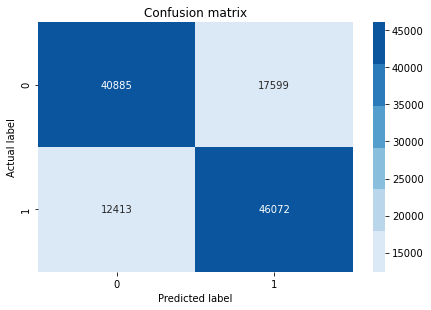

In [34]:
#Method 2: SVM
svc = LinearSVC(dual=False)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
metrics_plot(y_test,y_pred)

Accuracy: 0.7392813480494832
Precision: 0.7066310334135574
Recall: 0.818295289390442
F1 Score: 0.7583747979589897
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.72     58484
           1       0.71      0.82      0.76     58485

    accuracy                           0.74    116969
   macro avg       0.75      0.74      0.74    116969
weighted avg       0.75      0.74      0.74    116969



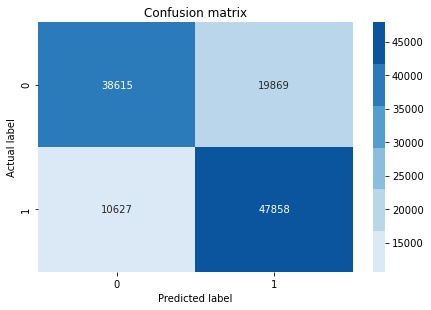

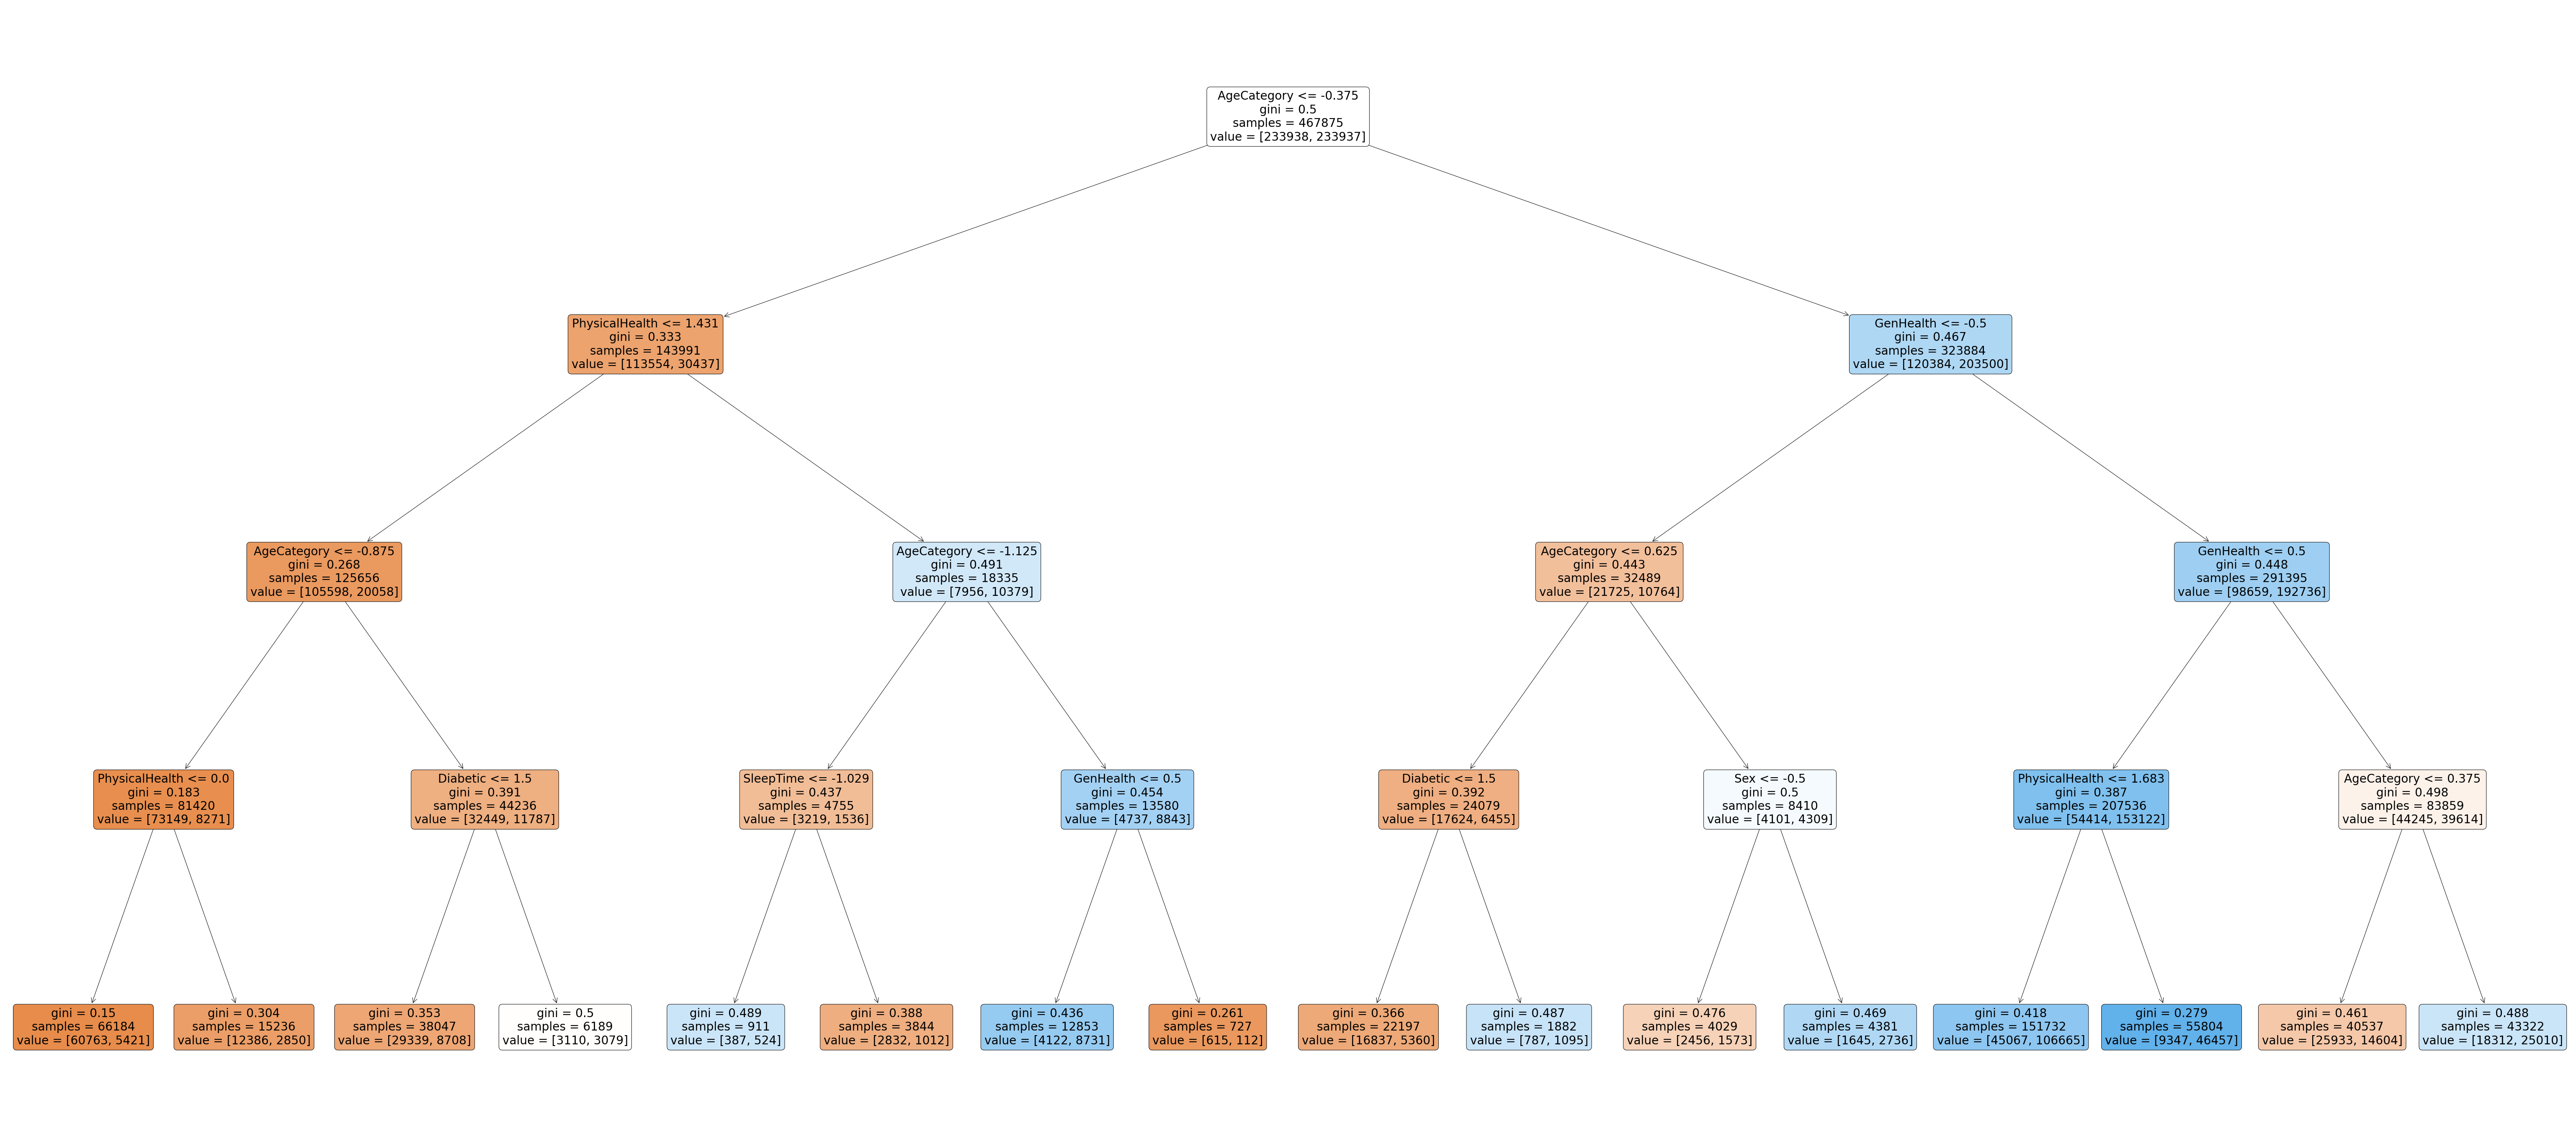

In [35]:
#Method 3: Decision Trees
#Model and predict
model_tree = tree.DecisionTreeClassifier(max_depth=4)
model_tree = model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)
metrics_plot(y_test,y_pred)
#Plot Decision Tree
plt.figure(figsize=(110,50))# set plot size (denoted in inches)
x = tree.plot_tree(model_tree, filled=True,feature_names=features,rounded=True,fontsize=28)
plt.show()

Accuracy: 0.8558763433046362
Precision: 0.8565481798715203
Recall: 0.8549371633752244
F1 Score: 0.8557419134006503
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     58484
           1       0.86      0.85      0.86     58485

    accuracy                           0.86    116969
   macro avg       0.86      0.86      0.86    116969
weighted avg       0.86      0.86      0.86    116969



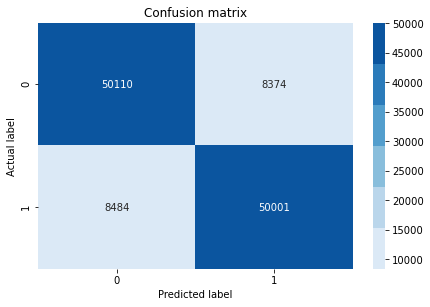

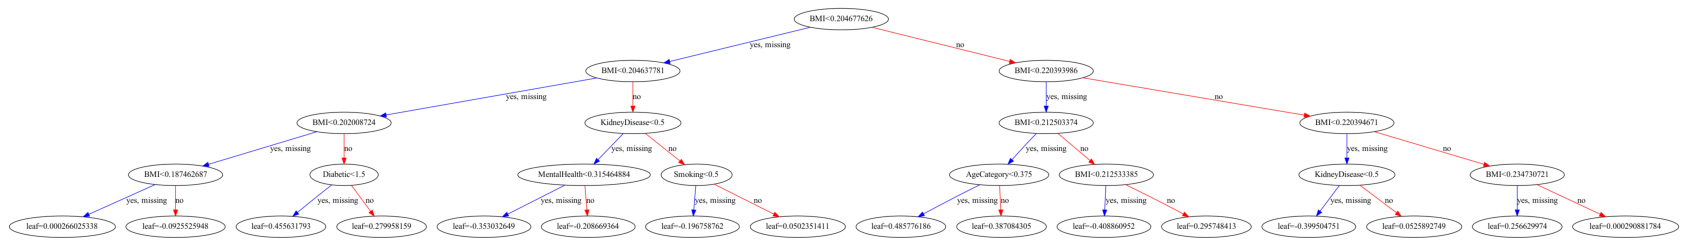

In [36]:
#Method4: Boosting
xgb = XGBClassifier(max_depth=4)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
metrics_plot(y_test,y_pred)
#Generate file with feature list for plot
with open('feature_map.txt', 'w') as f:
    for i in range(0,len(features)):
        f.write(str(i)+'\t'+features[i]+'\t'+'q'+'\n')
#Plot Decision Tree
plot_tree(xgb,num_trees=99, fmap='feature_map.txt')
fig = plt.gcf()
fig.set_size_inches(30, 15)

Accuracy: 0.7513101762005318
Precision: 0.7247263164332457
Recall: 0.8104642215952809
F1 Score: 0.765201107442953
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.69      0.74     58484
           1       0.72      0.81      0.77     58485

    accuracy                           0.75    116969
   macro avg       0.75      0.75      0.75    116969
weighted avg       0.75      0.75      0.75    116969



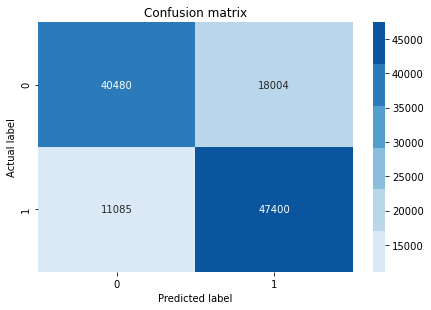

In [37]:
#Method 5: Stacking
estimators = [('svc',LinearSVC(dual=False)),('tr',tree.DecisionTreeClassifier(max_depth=4))]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
model_stack = stacking.fit(X_train, y_train)
y_pred = model_stack.predict(X_test)
metrics_plot(y_test,y_pred)

LR Accuracy: 0.740589 (0.000969)
LR Precision: 0.741752 (0.000960)
LR Recall: 0.740589 (0.000969)
SVC Accuracy: 0.740825 (0.001072)
SVC Precision: 0.742662 (0.001041)
SVC Recall: 0.740825 (0.001073)
DT Accuracy: 0.738366 (0.001191)
DT Precision: 0.744541 (0.001174)
DT Recall: 0.738366 (0.001191)
XG Accuracy: 0.856521 (0.001756)
XG Precision: 0.856532 (0.001759)
XG Recall: 0.856521 (0.001756)
ST Accuracy: 0.750590 (0.000843)
ST Precision: 0.753919 (0.000838)
ST Recall: 0.750590 (0.000843)


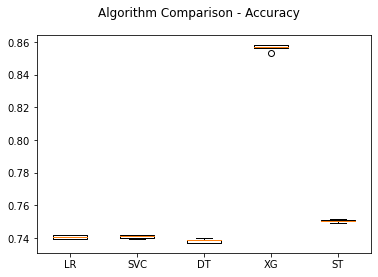

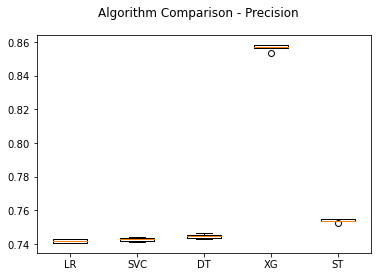

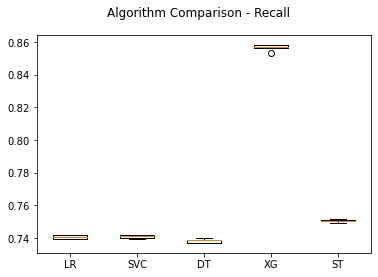

In [38]:
#Compare methods
X = transformation.fit_transform(X)
seed = 7
models = []
models.append(('LR', LogisticRegression()))
models.append(('SVC', LinearSVC(dual=False)))
models.append(('DT', tree.DecisionTreeClassifier(max_depth=4)))
models.append(('XG', XGBClassifier(max_depth=4)))
models.append(('ST', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())))

results_a = []
results_p = []
results_r = []
names = []
scoring = {'acc': 'accuracy','prec_macro': 'precision_macro','rec_macro': 'recall_macro'}
kfold = model_selection.StratifiedKFold(n_splits=5, random_state=seed,shuffle=True)
for name, model in models:
    cv_results = model_selection.cross_validate(model, X, y, cv=kfold, scoring=scoring)
    results_a.append(cv_results['test_acc'])
    results_p.append(cv_results['test_prec_macro'])
    results_r.append(cv_results['test_rec_macro'])
    names.append(name)
    msgA = "%s Accuracy: %f (%f)" % (name, cv_results['test_acc'].mean(), cv_results['test_acc'].std())
    print(msgA)
    msgP = "%s Precision: %f (%f)" % (name, cv_results['test_prec_macro'].mean(), cv_results['test_prec_macro'].std())
    print(msgP)
    msgR = "%s Recall: %f (%f)" % (name, cv_results['test_rec_macro'].mean(), cv_results['test_rec_macro'].std())
    print(msgR)
# boxplot algorithm comparison
fig = plt.figure(1)
fig.suptitle('Algorithm Comparison - Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results_a)
ax.set_xticklabels(names)
plt.show()
# boxplot algorithm comparison
fig = plt.figure(2)
fig.suptitle('Algorithm Comparison - Precision')
ax = fig.add_subplot(111)
plt.boxplot(results_p)
ax.set_xticklabels(names)
plt.show()
# boxplot algorithm comparison
fig = plt.figure(3)
fig.suptitle('Algorithm Comparison - Recall')
ax = fig.add_subplot(111)
plt.boxplot(results_r)
ax.set_xticklabels(names)
plt.show()